In [1]:
from statsImport import *

In [2]:
# Pull the data in from github
data = pd.read_csv('https://raw.githubusercontent.com/cjlortie/education.value/gh-pages/data/education.income.csv')
print('Original Dataset Size', data.shape)

# afqt is a non-data column so I'm going to drop it. 
# Also since I have +7000 datapoints and only a few rows with NA I'm going to drop all of those 
data.drop('afqt', axis='columns', inplace=True)
data.dropna(axis='index', inplace=True)
print('Dataset Size after NA drops', data.shape)
display(data.head())

# Let's see some simple descriptive statistics
display(data.describe())

n_males, n_females = len(data[data['sex'] == 'male']), len(data[data['sex'] == 'female'])
print('N Males =', n_males)
print('N Females =', n_females)

gender = data[['sex', 'height', 'weight']]
display(gender.head(3))

Original Dataset Size (7006, 8)
Dataset Size after NA drops (6901, 7)


,income,height,weight,age,marital,sex,education
0,19000,60,155.0,53,married,female,13.0
1,35000,70,156.0,51,married,female,10.0
2,105000,65,195.0,52,married,male,16.0
3,40000,63,197.0,54,married,female,14.0
4,75000,66,190.0,49,married,male,14.0


,income,height,weight,age,education
count,6901.000000,6901.000000,6901.000000,6901.000000,6901.000000
mean,41395.474714,67.138531,188.297783,51.321548,13.211274
std,56176.348480,4.085101,44.478239,2.234430,2.603954
min,0.000000,52.000000,76.000000,47.000000,1.000000
25%,300.000000,64.000000,157.000000,49.000000,12.000000
50%,30000.000000,67.000000,184.000000,51.000000,12.000000
75%,55000.000000,70.000000,212.000000,53.000000,15.000000
max,343830.000000,84.000000,524.000000,56.000000,20.000000


N Males = 3386
N Females = 3515


,sex,height,weight
0,female,60,155.0
1,female,70,156.0
2,male,65,195.0


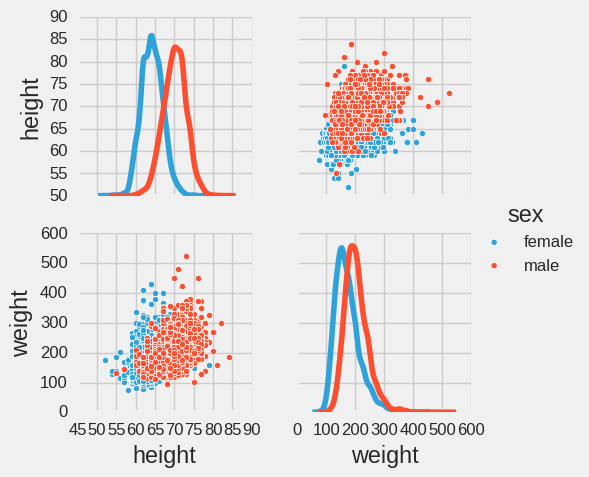

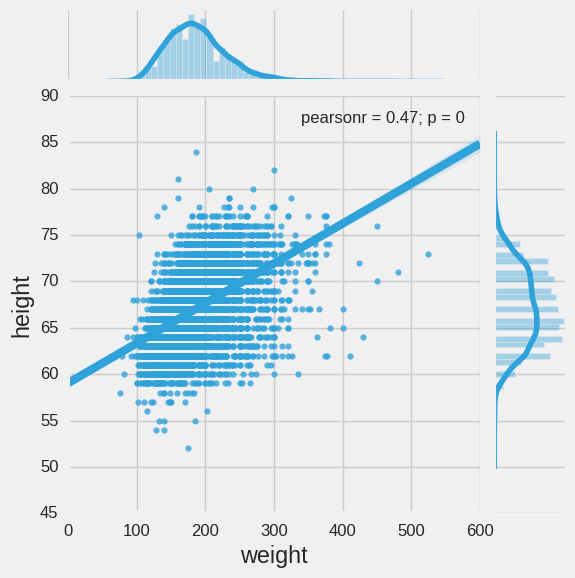

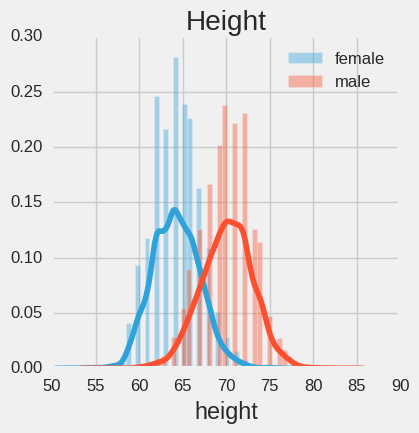

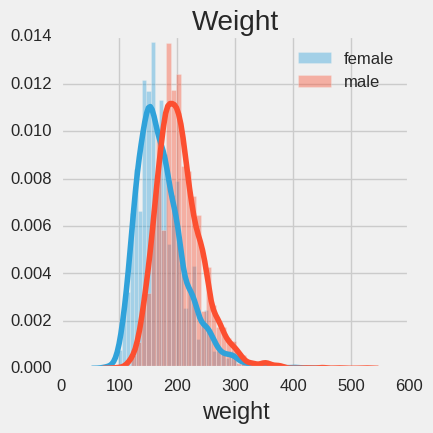

In [3]:
sns.pairplot(gender, hue='sex', diag_kind='kde')
graph.show()

graph.figure(figsize=(4, 4))
sns.jointplot(x='weight', y='height', data=gender, kind='reg')
graph.show()

graph.figure(figsize=(4, 4))
graph.title('Height')
sns.distplot(gender[gender.sex == 'female']['height'], label='female')
sns.distplot(gender[gender.sex == 'male']['height'], label='male')
graph.legend(loc=0)
graph.show()

graph.figure(figsize=(4, 4))
graph.title('Weight')
sns.distplot(gender[gender.sex == 'female']['weight'], label='female')
sns.distplot(gender[gender.sex == 'male']['weight'], label='male')
graph.legend(loc=0)
graph.show()

In [4]:
# Small data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

binariser = preprocessing.LabelBinarizer()

y = np.reshape(binariser.fit_transform(gender['sex'].values), (1, -1))[0]
x = gender[['height', 'weight']].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=1992)

# Separate These!

In [5]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression

In [6]:
# Decision Trees
tree = DecisionTreeClassifier(min_samples_split=3)
tree.fit(x_train, y_train)

export_graphviz(
    tree, 
    out_file='data/sex_weight_height_tree.dot',
    class_names=['female', 'male'],
    feature_names=gender.columns[1:]
)

print('Tree Train Score 2 Features:', tree.score(x_train, y_train))
print('Tree Test Score 2 Features :', tree.score(x_test, y_test))

Tree Train Score 2 Features: 0.884299516908
Tree Test Score 2 Features : 0.825425570445


### Height and Weight Tree

<a href='data/sex_weight_height_tree.png'><img src='data/sex_weight_height_tree.png' /></a>

Sooo I wonder if this tree is overfitting or just absurdly complex for another reason...

In [7]:
# Logistic Regression
logit = LogisticRegression()
logit.fit(x_train, y_train)

print('Logit Train Score 2 Features:', logit.score(x_train, y_train))
print('Logit Test Score 2 Features :', logit.score(x_test, y_test))
print(logit.coef_, logit.intercept_)

Logit Train Score 2 Features: 0.838888888889
Logit Test Score 2 Features : 0.851865266208
[[ 0.31423054  0.00511517]] [-22.07654444]


Notice that the logistic regression does not use the 'weight' feature to make the predictions (we are using L2 regularisation). L2 regularisation has removed the second feature from the model. It can be interpreted as saying that knowing someone's height alone will make it 85.1% sure what there gender is. Which is pretty awesome. 

In [10]:
# Decision Tree on Height alone
x_height_train, x_height_test = x_train[:, 0], x_test[:, 0]
x_height_train, x_height_test = x_height_train.reshape(-1, 1), x_height_test.reshape(-1, 1)

tree_height = DecisionTreeClassifier(min_samples_split=3)
tree_height.fit(x_height_train, y_train)

export_graphviz(
    tree_height, 
    out_file='data/sex_height_tree.dot',
    class_names=['female', 'male'],
    feature_names='height'
)

print('Tree Height Train Score 2 Features:', tree_height.score(x_height_train, y_train))
print('Tree Height Test Score 2 Features :', tree_height.score(x_height_test, y_test))

Tree Height Train Score 2 Features: 0.843961352657
Tree Height Test Score 2 Features : 0.855124954727


### Height Only Tree

<a href='data/sex_height_tree.png'><img src='data/sex_height_tree.png' /></a>

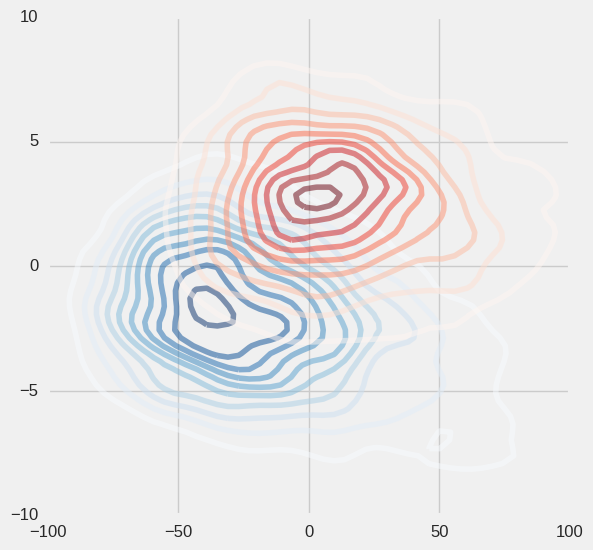

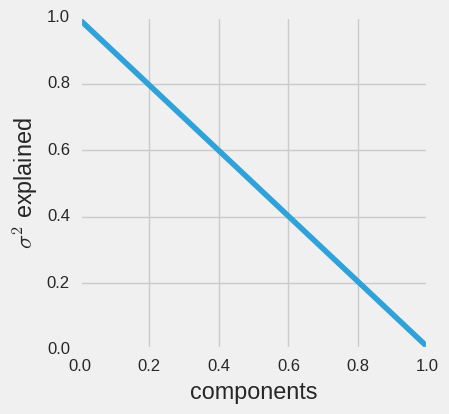

In [8]:
# PCA features for decision trees
from sklearn.decomposition import PCA

pca = PCA()
x_pca = pca.fit_transform(x)

graph.figure(figsize=(6, 6))
sns.kdeplot(x_pca[y == 0, 0], x_pca[y == 0, 1], 
            shade=False, shade_lowest=False, cmap='Blues', n_levels=10, alpha=0.5)
sns.kdeplot(x_pca[y == 1, 0], x_pca[y == 1, 1], 
            shade=False, shade_lowest=False, cmap='Reds', n_levels=10, alpha=0.5)
graph.xlim([-100, 100])
graph.ylim([-10, 10])
graph.show()

graph.figure(figsize=(4, 4))
graph.plot(pca.explained_variance_ratio_)
graph.ylabel(r'$ \sigma^2 $ explained')
graph.xlabel('components')
graph.show()

The first component explains basically 100% of the variation which is what we expected. 

In [9]:
x_pca_train, x_pca_test, y_train, y_test = train_test_split(x_pca[:, 0], y, test_size=0.4, random_state=1992)
x_pca_train, x_pca_test = x_pca_train.reshape(-1, 1), x_pca_test.reshape(-1, 1)
print(x_pca_train.shape, x_pca_test.shape, y_train.shape, y_test.shape)

tree_pca = DecisionTreeClassifier(min_samples_split=3)
tree_pca.fit(x_pca_train, y_train)

export_graphviz(
    tree_pca, 
    out_file='data/sex_pca_tree.dot',
    class_names=['female', 'male']
)

print('Tree Train Score 2 Features:', tree_pca.score(x_pca_train, y_train))
print('Tree Test Score 2 Features :', tree_pca.score(x_pca_test, y_test))

(4140,) (2761,) (4140,) (2761,)
Tree Train Score 2 Features: 0.881642512077
Tree Test Score 2 Features : 0.810575878305


### Height and Weight principle component

<a href='data/sex_pca_tree.png'><img src='data/sex_pca_tree.png' /></a>